In [1]:
from util import get_kitty_data_dir2012,load_model,output_embedding,produce_stereo_matching
from sklearn.preprocessing import LabelEncoder
from skimage import io
import mxnet as mx
import numpy as np
import time
import densecrf as dcrf
import matplotlib.pyplot as plt
import cv2
import skimage as ski
from scipy import ndimage,signal,stats
%matplotlib inline

In [2]:
def generate_ms(ctx,dis_range): 
    img_dir = get_kitty_data_dir(0,1)
    for num,img in enumerate(img_dir):
        ms,left,right = output_matchingscore(img[1],img[2],dis_range,ctx)
        np.save('./matching_score/%d' % num,ms)
def outlier_sum(pred,gt,tau=3):
    #gt = gt[6:gt.shape[0]-6,6:gt.shape[1]-6]
    outlier = np.zeros(gt.shape)
    mask = gt > 0
    gt = gt[mask]/256.0
    pred = pred[mask]
    err = np.abs(pred-gt)
    outlier[mask] = err
    plt.figure()
    plt.imshow(outlier)
      
    return (err[err>tau]/gt[err>tau].astype(np.float32) > 0.05).sum()/float(mask.sum()),outlier

def compute_unary(ms,class_num,GT_PROB,tau):
    u = ms.reshape(-1,class_num).T
    u[0,:] = 0.0
    tot = u.T.sum(axis=1)
    u = u/tot
    mask = u.max(axis=0) < tau
    u[:,mask] = np.ones((class_num,sum(mask))) * 0.00001
    u = np.ascontiguousarray(u)
    return (-np.log(u)).astype(np.float32)

消耗时间 : 14.594445 s fine scale :0.760006 coalse scale :0.057209
mrf outlier : 0.390165
median filter outlier : 0.338775
消耗时间 : 34 s


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


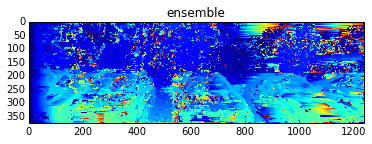

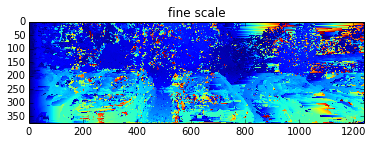

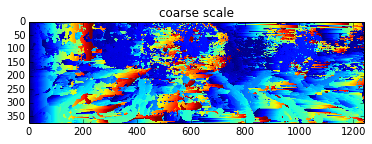

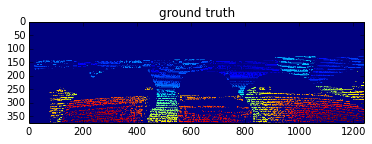

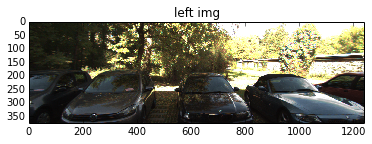

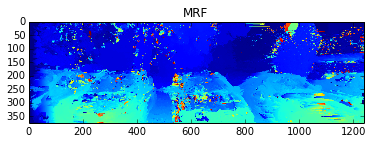

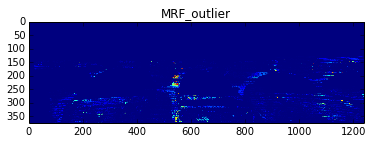

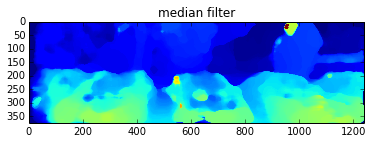

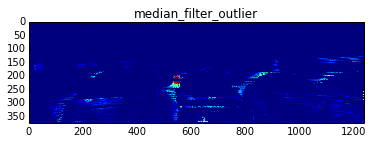

In [10]:
dis_num = 227
begin = time.time()
dirs = get_kitty_data_dir2012(180,181)
args,dis,dis1,dis2,ms,ms1,ms2,w1,w2 = produce_stereo_matching(dirs[0],mx.gpu(3),dis_num,30)

plt.figure()
plt.imshow(dis)
plt.title('ensemble')

plt.figure()
plt.imshow(dis1)
plt.title('fine scale')

plt.figure()
plt.imshow(dis2)
plt.title('coarse scale')

plt.figure()
gt = io.imread(dirs[0][0])
plt.imshow(gt)
plt.title('ground truth')

plt.figure()
io.imshow(dirs[0][1])
plt.title('left img')
print '消耗时间 : %f s fine scale :%f coalse scale :%f' % (time.time() - begin, w1,w2)

#---------------------------------------------mrf---------------------------
left = io.imread(dirs[0][1])
#left = left[6:left.shape[0]-6,6:left.shape[1]-6]

d = dcrf.DenseCRF2D(dis.shape[1],dis.shape[0],dis_num)
u = compute_unary(ms,dis_num,0.7,0.0054)

d.setUnaryEnergy(u)
left = np.ascontiguousarray(left)
d.addPairwiseBilateral(sxy=(15,15), srgb=(13, 13, 13), rgbim=left,
                       compat=30,
                       kernel=dcrf.FULL_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)
dis_map = np.argmax(Q, axis=0).reshape(dis.shape[:2])

plt.figure()
plt.imshow(dis_map)
plt.title('MRF')
err,outlier = outlier_sum(dis_map,gt,3)
plt.title('MRF_outlier')
print  'mrf outlier : %f' % err

#-------------------------------------------median filter--------------------
plt.figure()
tmp = signal.medfilt2d(dis_map.astype(np.float32),27)
plt.imshow(tmp)
plt.title('median filter')

err,outlier = outlier_sum(tmp,gt,3)
plt.title('median_filter_outlier')

print 'median filter outlier : %f' % err
print  '消耗时间 : %d s' % (time.time() - begin)

In [7]:
cv

374